# Project Ensamble Techniques
Using the data collected from existing customers, build a model that will help the marketing team identify potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio. 

<h2>1. Exploratory Data quality </h2>

In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score
from yellowbrick.classifier import ClassificationReport, ROCAUC
from IPython.display import Image
from os import system
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('bank-full.csv')

In [3]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Perhaps we should fix the columns:<br>
1) Pdays (negative values) can we use 0?<br>
2) education: unknown values <br>
3) marital: we can create new columns from marital (married, single, divorced)<br>
4) job: not sure <br>
5) poutcome: create dummies maybe is important<br>
6) loan: yes=1, no=0<br>
7) housing: yes=1, no=0<br>

In [5]:
df.loc[df["pdays"] == -1, "pdays"] = 0
df["Target"] = df["Target"].map({"yes": 1, "no": 0})
df["housing"] = df["housing"].map({"yes": 1, "no": 0})
df["loan"] = df["loan"].map({"yes": 1, "no": 0})
df["default"] = df["default"].map({"yes": 1, "no": 0})

In [6]:
# Creating dummy variables from marital status
dummies = pd.get_dummies(df['marital']).rename(columns=lambda x: str(x))
df = pd.concat([df, dummies], axis=1)
#remove marital column
df.drop('marital', axis=1, inplace=True)

In [7]:
# Creating dummy variables from marital status
dummies = pd.get_dummies(df['poutcome']).rename(columns=lambda x: 'poutcome_'+str(x))
df = pd.concat([df, dummies], axis=1)
#remove marital column
df.drop('poutcome', axis=1, inplace=True)

In [8]:
df.head()

,age,job,education,default,balance,housing,loan,contact,day,month,...,pdays,previous,Target,divorced,married,single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,management,tertiary,0,2143,1,0,unknown,5,may,...,0,0,0,0,1,0,0,0,0,1
1,44,technician,secondary,0,29,1,0,unknown,5,may,...,0,0,0,0,0,1,0,0,0,1
2,33,entrepreneur,secondary,0,2,1,1,unknown,5,may,...,0,0,0,0,1,0,0,0,0,1
3,47,blue-collar,unknown,0,1506,1,0,unknown,5,may,...,0,0,0,0,1,0,0,0,0,1
4,33,unknown,unknown,0,1,0,0,unknown,5,may,...,0,0,0,0,0,1,0,0,0,1


In [9]:
columns = df.describe().columns
df = df.loc[:, df.columns.isin(list(columns))]

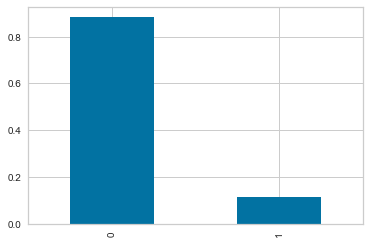

In [10]:
df["Target"].value_counts(normalize=True).plot(kind='bar')

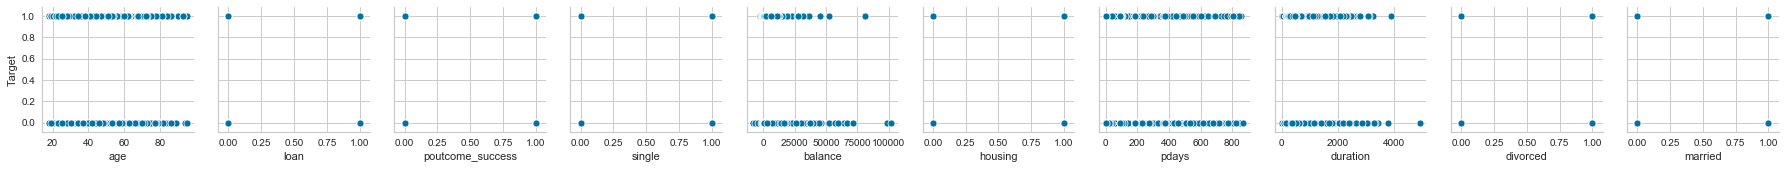

In [11]:
sns.pairplot(data=df, y_vars=['Target'], x_vars=["age", "loan", "poutcome_success", "single", 
                                                 "balance", "housing", "pdays", "duration", "divorced", "married"],
             palette="husl")

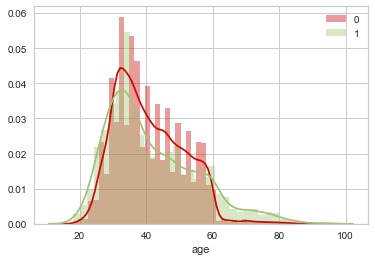

In [12]:
sns.distplot(df[df['Target']==0]['age'],color='r',label=0)
sns.distplot(df[df['Target']==1]['age'],color='g',label=1)
plt.legend()
plt.show()

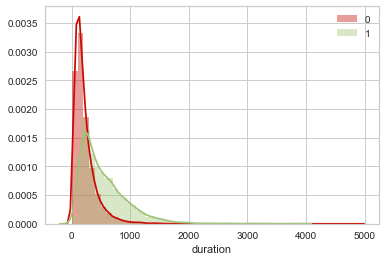

In [13]:
sns.distplot(df[df['Target']==0]['duration'],color='r',label=0)
sns.distplot(df[df['Target']==1]['duration'],color='g',label=1)
plt.legend()
plt.show()

#Maybe the more a campaign last the less successful sale we have

In [14]:
df.corr()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,Target,divorced,married,single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.017879,0.097783,-0.185513,-0.015655,-0.009120,-0.004648,0.004760,-0.023841,0.001288,0.025155,0.164674,0.286257,-0.427817,-0.004927,-0.022967,0.035526,-0.000816
default,-0.017879,1.000000,-0.066745,-0.006025,0.077234,0.009424,-0.010021,0.016822,-0.029927,-0.018329,-0.022419,0.017777,-0.014460,0.003115,-0.026389,-0.014445,-0.023344,0.039490
balance,0.097783,-0.066745,1.000000,-0.068768,-0.084350,0.004503,0.021560,-0.014578,0.003330,0.016674,0.052838,-0.021732,0.025708,-0.012537,0.011857,0.008466,0.035240,-0.030271
housing,-0.185513,-0.006025,-0.068768,1.000000,0.041323,-0.027982,0.005075,-0.023599,0.124350,0.037076,-0.139173,0.001778,0.017681,-0.020475,0.106795,0.039710,-0.091360,-0.063755
loan,-0.015655,0.077234,-0.084350,0.041323,1.000000,0.011370,-0.012412,0.009980,-0.022709,-0.011043,-0.068185,0.016377,0.036906,-0.051716,-0.002186,-0.009099,-0.053713,0.031406
day,-0.009120,0.009424,0.004503,-0.027982,0.011370,1.000000,-0.030206,0.162490,-0.093024,-0.051710,-0.028348,-0.000433,0.007102,-0.007412,-0.068700,-0.032952,-0.030321,0.086256
duration,-0.004648,-0.010021,0.021560,0.005075,-0.012412,-0.030206,1.000000,-0.084570,-0.001584,0.001203,0.394521,0.006100,-0.022683,0.020328,-0.018925,-0.001958,0.042389,-0.003491
campaign,0.004760,0.016822,-0.014578,-0.023599,0.009980,0.162490,-0.084570,1.000000,-0.088508,-0.032855,-0.073172,-0.015484,0.031371,-0.023120,-0.088131,-0.020107,-0.057486,0.107965
pdays,-0.023841,-0.029927,0.003330,0.124350,-0.022709,-0.093024,-0.001584,-0.088508,1.000000,0.454288,0.103323,0.002920,-0.027591,0.027916,0.700558,0.389417,0.227786,-0.869022
previous,0.001288,-0.018329,0.016674,0.037076,-0.011043,-0.051710,0.001203,-0.032855,0.454288,1.000000,0.093236,-0.004534,-0.012691,0.017006,0.350627,0.306615,0.201424,-0.532763


In [15]:
# I think we can work with this dependent variables: age, balance, pdays, poutcome_success
# Nevertheless all variables have a week correlation to our independent variable (Target) im not sure what could happen

<h2>2. Prepare the data for analytics </h2>

In [16]:
#i did select only numerical variables
df.dtypes 

age                 int64
default             int64
balance             int64
housing             int64
loan                int64
day                 int64
duration            int64
campaign            int64
pdays               int64
previous            int64
Target              int64
divorced            uint8
married             uint8
single              uint8
poutcome_failure    uint8
poutcome_other      uint8
poutcome_success    uint8
poutcome_unknown    uint8
dtype: object

In [17]:
#Split the data using train split
from sklearn.model_selection import train_test_split
X = df.drop('Target',axis=1)
Y = df['Target']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

<h2>3. Create the ensemble model </h2>

#### Lets create some helping functions:

In [18]:
def show_tree(dot_file, output_image):
    retCode = system("dot -Tpng "+dot_file+" -o "+output_image)
    if retCode>0:
        print("system command returning error: "+str(retCode))
    else:
        display(Image(output_image))

In [19]:
def print_confusion_matrix(test, predict):
    cm=confusion_matrix(test, predict, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index = ["1","0"], columns = ["Predict 1","Predict 0"])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True)

In [20]:
#lets create a report function, we will need it later
def model_report(model, xtrain, ytrain, xtest, ytest, reporter=None):
    if reporter:
        viz = ClassificationReport(RandomForestClassifier(n_estimators=50))
    else:
        viz = ClassificationReport(model)
    viz.fit(xtrain, ytrain)
    viz.score(xtest, ytest)
    viz.show()
    roc = ROCAUC(model)
    roc.fit(xtrain, ytrain)
    roc.score(xtest, ytest)
    roc.show()

In [21]:
#Lets start with LogisticRegression
model_log = LogisticRegression(solver="liblinear")
model_log.fit(x_train, y_train)
#predict on test
y_predict = model_log.predict(x_test)

In [22]:
model_score = model_log.score(x_test, y_test)
print(model_score)

#Is this real? 90% score?

0.8998820406959599


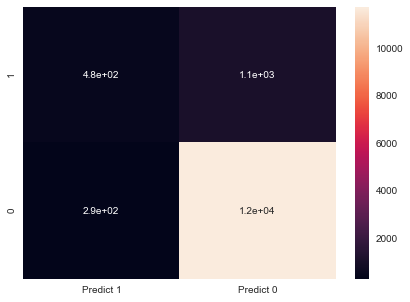

In [23]:
#Lets print the confusion matrix
print_confusion_matrix(y_test, y_predict)

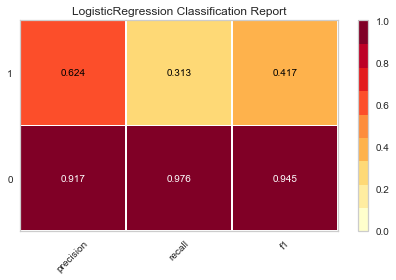

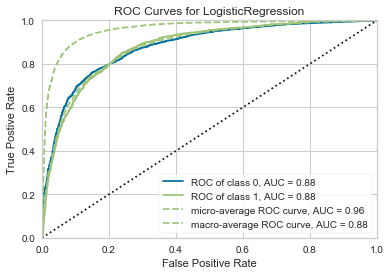

In [24]:
#Lets print the report model
model_report(model_log, x_train, y_train, x_test, y_test)

In [25]:
# Now Lets check decision tree (gini, entropy? which one is better?)
model_tree = DecisionTreeClassifier(criterion = 'gini', random_state=1, max_depth=3)
model_tree.fit(x_train, y_train)

#it doesn't change that much between gini vs entropy

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [26]:
model_tree.score(x_test, y_test)

0.9012828074314362

In [27]:
train_char_label = ['0', '1']
Project_Tree_File = open('project_tree.dot','w')
dot_data = tree.export_graphviz(model_tree, out_file=Project_Tree_File, feature_names = list(x_train), 
                                class_names = list(train_char_label))
Project_Tree_File.close()

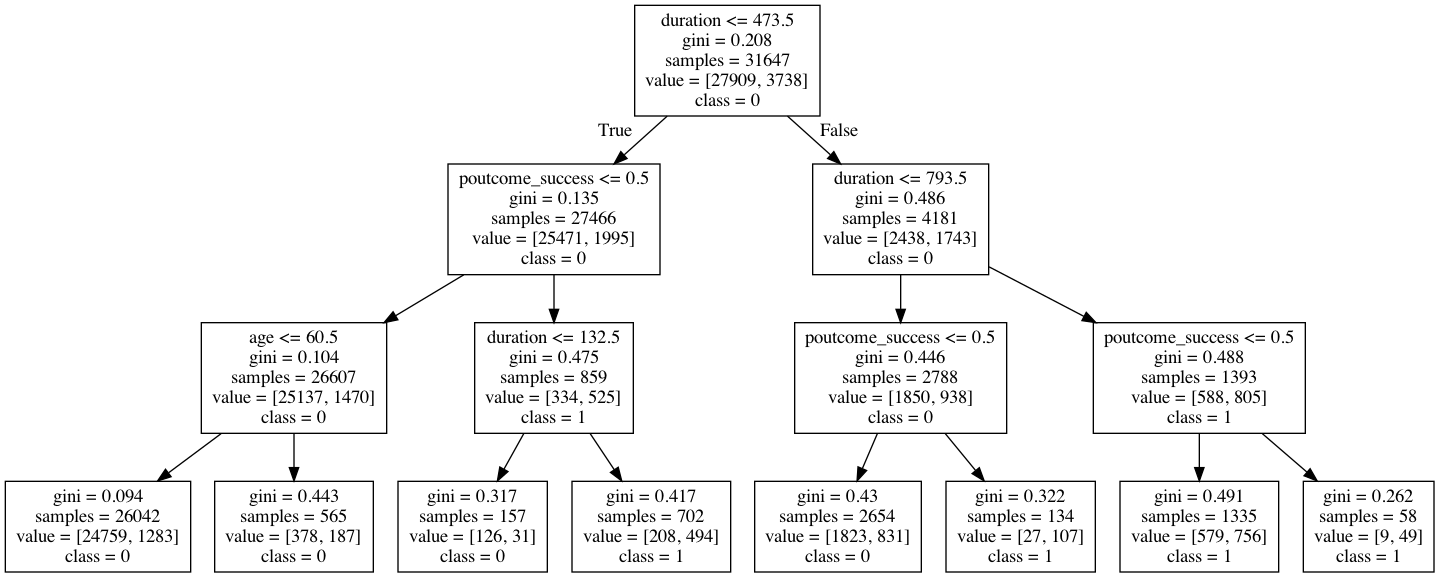

In [28]:
show_tree('project_tree.dot', 'project_dtree.png')

In [29]:
y_predict = model_tree.predict(x_test)

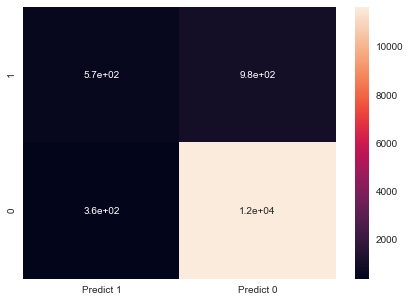

In [30]:
print_confusion_matrix(y_test, y_predict)

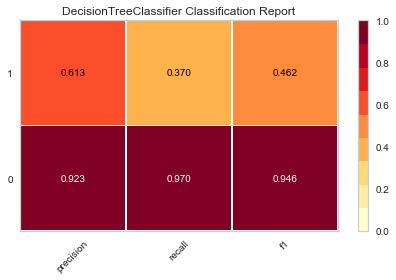

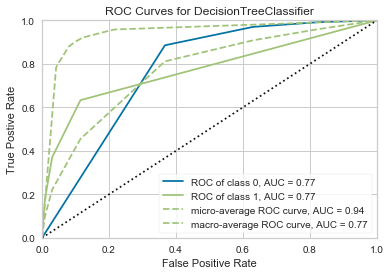

In [31]:
model_report(model_tree, x_train, y_train, x_test, y_test)

In [32]:
## Different approach lets split the data
n=df['Target'].count()
train_set = df.head(int(round(n*0.7))) # Up to the last initial training set row
test_set = df.tail(int(round(n*0.3))) # Past the last initial training set row

# capture the target column ("class") into separate vectors for training set and test set
train_labels = train_set.pop("Target")
test_labels = test_set.pop("Target")

### a) Random Forest 

In [33]:
ranfo = RandomForestClassifier(criterion = 'gini', max_depth = 5, min_samples_leaf=5)
ranfo.fit(train_set, train_labels)
y_predict = ranfo.predict(test_set)
ranfo_score = ranfo.score(test_set, test_labels)
print(ranfo_score)
ranfo_df = pd.DataFrame({'Method':['Random Forest'], 'accuracy': ranfo_score})

0.7474010174740102


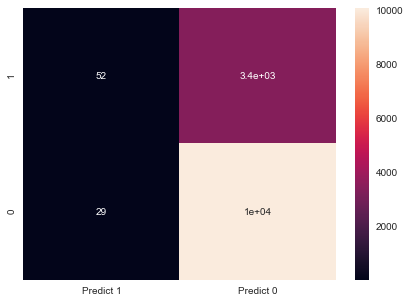

In [34]:
# Confusion matrix for Random forest
print_confusion_matrix(test_labels, y_predict)

### b) Ada Boost

In [35]:
ada = AdaBoostClassifier(n_estimators=30)
ada.fit(train_set, train_labels)
ada_predict = ada.predict(test_set)
ada_score = ada.score(test_set, test_labels)
print(ada_score)
ada_df = pd.DataFrame({'Method':['Boosting'], 'accuracy': ada_score})

0.7728378677283787


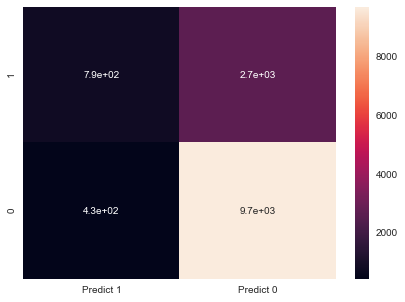

In [36]:
#Confusion matrix for Ada Boost
print_confusion_matrix(test_labels, ada_predict)

### c) Bagging

In [37]:
bagg = BaggingClassifier(n_estimators=10, max_samples= .7, bootstrap=True)
bagg.fit(train_set, train_labels)
bagg_predict = bagg.predict(test_set)
bagg_score = bagg.score(test_set, test_labels)
print(bagg_score)
bagg_df = pd.DataFrame({'Method':['Bagging'], 'accuracy': bagg_score})

0.7524146575241466


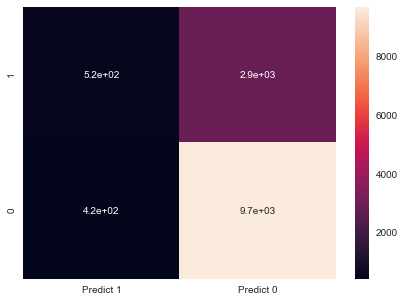

In [38]:
#Confusion matrix for bagging
print_confusion_matrix(test_labels, bagg_predict)

### Lets compare all models

In [39]:
pd.concat([ranfo_df, ada_df, bagg_df])

,Method,accuracy
0,Random Forest,0.747401
0,Boosting,0.772838
0,Bagging,0.752415


According with the result the best model with better accuracy is Boosting although this model works better with week classifiers i found that the rest of the models are not that bad. I think the improvement comes with the number of iterations that was been set for this classifier. Nevertheless i don't have strong evidence the reason on this.

The question here is, why don't use Decision Tree, AUC is high and it has a good accurancy, but also has higher number of false positives.

Also ADA Boosting has a better ROC compared with the rest of the models.

### Ada Report

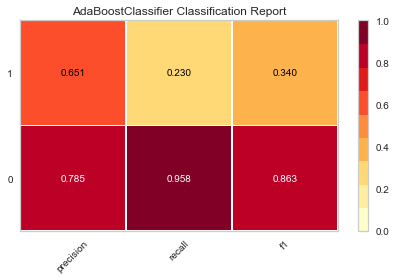

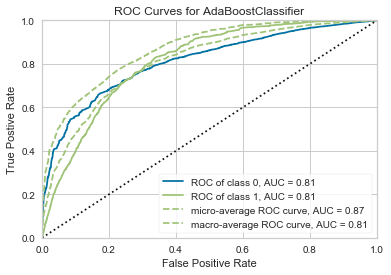

In [40]:
viz = ClassificationReport(AdaBoostClassifier(n_estimators=30))
viz.fit(train_set, train_labels)
viz.score(test_set, test_labels)
viz.show()
roc = ROCAUC(ada)
roc.fit(train_set, train_labels)
roc.score(test_set, test_labels)
roc.show()